In [339]:
import re
import json
import requests
import numpy as np

import pandas as pd
#Display all rows
pd.set_option('display.max_rows', None)
#Display all columns
pd.set_option('display.max_columns', None)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from geopy.geocoders import Nominatim

import folium

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

print('Libraries imported.')

Libraries imported.


In [340]:
#Import California Lat/Long data set
#https://www.kaggle.com/camnugent/california-housing-feature-engineering
cal_city_data = pd.read_csv('cal_cities_lat_long.csv')
cal_city_data.head()

,Name,Latitude,Longitude
0,Adelanto,34.582769,-117.409214
1,Agoura Hills,34.153339,-118.761675
2,Alameda,37.765206,-122.241636
3,Albany,37.886869,-122.297747
4,Alhambra,34.095286,-118.127014


In [341]:
address = 'California'
geolocator = Nominatim(user_agent="California")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of California is {}, {}.'.format(latitude, longitude))

The geographical coordinate of California is 36.7014631, -118.755997.


In [342]:
# create map of California using latitude and longitude values
cal_city_map = folium.Map(location=[latitude, longitude], zoom_start=7)    
cal_city_map

In [343]:
# add neighborhood markers to map
for lat, lng, location in zip(cal_city_data['Latitude'], cal_city_data['Longitude'], cal_city_data['Name']):
    label = '{}'.format(location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(cal_city_map)  

cal_city_map

In [344]:
CLIENT_ID = 'RTQWZEWSSGNRNYHZKWRSQK2DJN5VHZMZH1WRYEHJZWNP5K5R'
CLIENT_SECRET = 'HA1XI5JAB5FIIP0LTPP1WM12HDZAFSGJIXE5TYMJILYGDZ5I'
VERSION = '20180604'

In [345]:
def getNearbyVenues(names, latitudes, longitudes):
    radius=500
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [347]:
cal_city_venues = getNearbyVenues(names = cal_city_data['Name'],
                                 latitudes = cal_city_data['Latitude'],
                                 longitudes = cal_city_data['Longitude']
                                 )

print(cal_city_venues.shape)
cal_city_venues.head()

Adelanto


KeyError: 'groups'

In [348]:
cal_city_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adelanto,1,1,1,1,1,1
Agoura Hills,24,24,24,24,24,24
Alameda,80,80,80,80,80,80
Albany,49,49,49,49,49,49
Alhambra,74,74,74,74,74,74
Aliso Viejo,69,69,69,69,69,69
Alturas,10,10,10,10,10,10
Amador City,6,6,6,6,6,6
American Canyon,5,5,5,5,5,5


In [349]:
print('There are {} uniques categories.'.format(len(cal_city_venues['Venue Category'].unique())))

There are 409 uniques categories.


<AxesSubplot:xlabel='Neighborhood'>

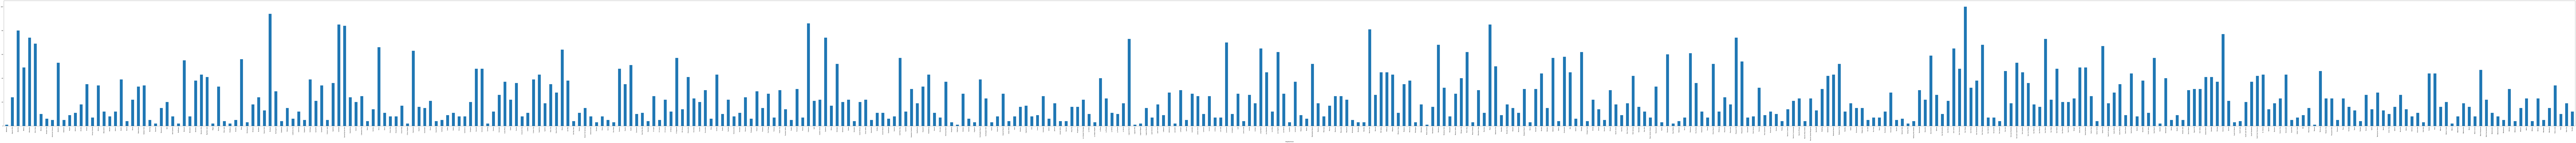

In [384]:
df = cal_city_venues.groupby(['Neighborhood'], sort=False)['Venue'].count()
df.plot.bar(figsize=(400,20))

<AxesSubplot:xlabel='Neighborhood'>

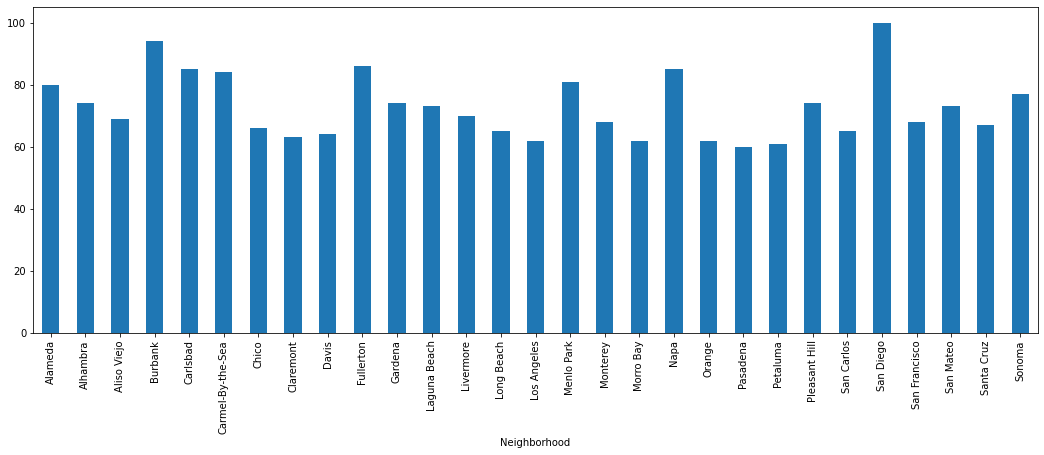

In [351]:
df = df[df >= 60]
df.plot.bar(figsize=(18,6))

In [352]:
cal_city_venues_top = cal_city_venues[cal_city_venues['Neighborhood'].isin(df.index.tolist())]
cal_city_venues_top.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
25,Alameda,37.765206,-122.241636,The Star,37.764200,-122.242711,Pizza Place
26,Alameda,37.765206,-122.241636,Tucker's Ice Cream,37.763843,-122.243297,Ice Cream Shop
27,Alameda,37.765206,-122.241636,Troy,37.764388,-122.243365,Middle Eastern Restaurant
28,Alameda,37.765206,-122.241636,American Oak,37.765739,-122.242426,Bar
29,Alameda,37.765206,-122.241636,Alameda Theatre & Cineplex,37.764680,-122.243946,Multiplex


In [353]:
cal_city_onehot = pd.get_dummies(cal_city_venues_top['Venue Category'], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cal_city_onehot['Neighborhood'] = cal_city_venues_top['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = cal_city_onehot.columns.tolist()
fixed_columns.insert(0, fixed_columns.pop(fixed_columns.index('Neighborhood')))
cal_city_onehot = cal_city_onehot.reindex(columns = fixed_columns)

print(cal_city_onehot.shape)
cal_city_onehot.head()

(2112, 258)


,Neighborhood,ATM,Accessories Store,Afghan Restaurant,American Restaurant,Andhra Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Bay,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burmese Restaurant,Burrito Place,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Store,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Latin American Restaurant,Leather Goods Store,Library,Lingerie Store,Liquor Store,Lounge,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Mongolian Restaurant,Motel,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Other Nightlife,Paintball Field,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool Hall,Portuguese Restaurant,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,School,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Street Food Gathering,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Yoshoku Restaurant,Zoo Exhibit
25,Alameda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [354]:
cal_city_grouped = cal_city_onehot.groupby('Neighborhood').mean().reset_index()
print(cal_city_grouped.shape)
cal_city_grouped.head()

(29, 258)


,Neighborhood,ATM,Accessories Store,Afghan Restaurant,American Restaurant,Andhra Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Bay,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burmese Restaurant,Burrito Place,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Store,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Latin American Restaurant,Leather Goods Store,Library,Lingerie Store,Liquor Store,Lounge,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Mongolian Restaurant,Motel,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Other Nightlife,Paintball Field,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool Hall,Portuguese Restaurant,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,School,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Street Food Gathering,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Yoshoku Restaurant,Zoo Exhibit
0,Alameda,0.012500,0.000000,0.0125,0.025000,0.0,0.000000,0.0,0.012500,0.0,0.000000,0.0,0.0,0.025000,0.0,0.000000,0.000000,0.012500,0.025000,0.000000,0.025000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.012500,0.000000,0.0,0.012500,0.012500,0.0125,0.000000,0.0,0.012500,0.012500,0.0125,0.0,0.0,0.012500,0.0,0

In [355]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [356]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create column names according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = cal_city_grouped['Neighborhood']

for ind in np.arange(cal_city_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cal_city_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(29)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alameda,Chinese Restaurant,Sandwich Place,Thai Restaurant,Nail Salon,Italian Restaurant,New American Restaurant,Dessert Shop,Mexican Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant
1,Alhambra,Bakery,Burger Joint,Café,Mobile Phone Shop,Shopping Mall,Bubble Tea Shop,Seafood Restaurant,Dessert Shop,Vietnamese Restaurant,Cocktail Bar
2,Aliso Viejo,Mobile Phone Shop,Fast Food Restaurant,Mexican Restaurant,Sandwich Place,Pizza Place,Furniture / Home Store,Juice Bar,Thai Restaurant,Spa,Bagel Shop
3,Burbank,Clothing Store,American Restaurant,Ice Cream Shop,Sandwich Place,Mexican Restaurant,Furniture / Home Store,Japanese Restaurant,Burger Joint,Asian Restaurant,Shoe Store
4,Carlsbad,Mexican Restaurant,Italian Restaurant,American Restaurant,Bar,Café,Hotel,Restaurant,Ice Cream Shop,Pizza Place,Coffee Shop
5,Carmel-By-the-Sea,Hotel,Italian Restaurant,Bed & Breakfast,Breakfast Spot,Café,Seafood Restaurant,Mediterranean Restaurant,Jewelry Store,New American Restaurant,Coffee Shop
6,Chico,Bar,Pizza Place,Breakfast Spot,Coffee Shop,Italian Restaurant,Farmers Market,American Restaurant,BBQ Joint,Bakery,Burger Joint
7,Claremont,Arts & Crafts Store,Pizza Place,Coffee Shop,American Restaurant,Mediterranean Restaurant,Bakery,Italian Restaurant,Mexican Restaurant,Gastropub,Bank
8,Davis,Ice Cream Shop,Mexican Restaurant,Coffee Shop,Sushi Restaurant,Pizza Place,American Restaurant,Indian Restaurant,Bakery,Burger Joint,Thai Restaurant
9,Fullerton,Bar,Coffee Shop,Pizza Place,Korean Restaurant,Train Station,Sushi Restaurant,Café,Italian Restaurant,Sandwich Place,Sports Bar


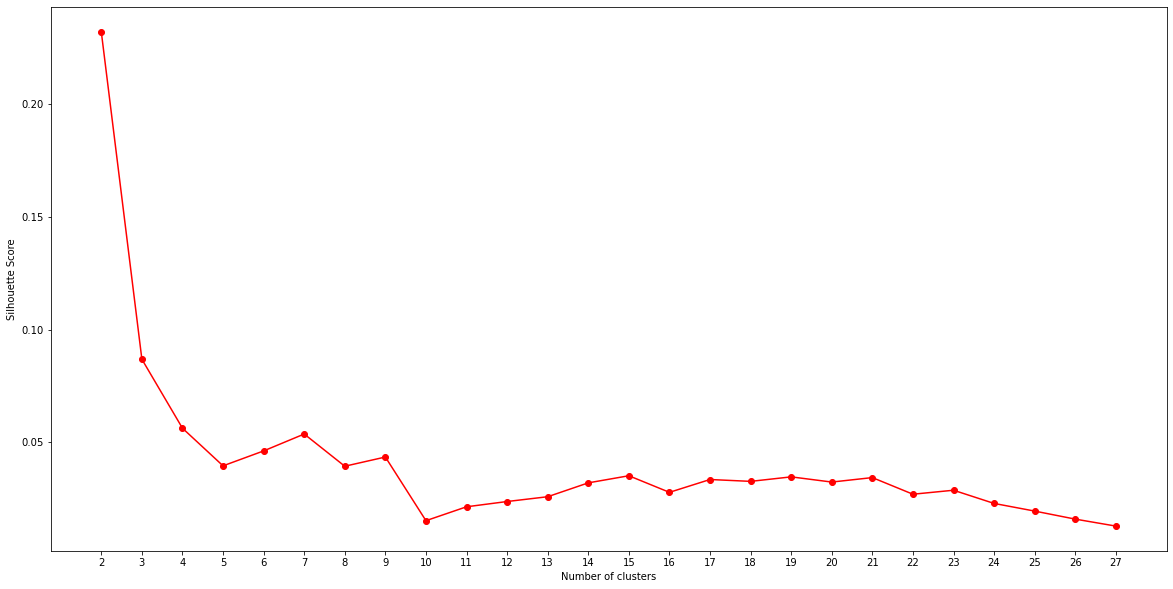

In [357]:
cal_city_grouped_clustering = cal_city_grouped.drop('Neighborhood', 1)

max_score = 28
scores = []

for kclusters in range(2, max_score):
    # Run k-means clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(cal_city_grouped_clustering)
    
    # Gets the silhouette score
    score = silhouette_score(cal_city_grouped_clustering, kmeans)
    scores.append(score)

plt.figure(figsize=(20,10))
plt.plot(np.arange(2, max_score), scores, 'ro-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.xticks(np.arange(2, max_score))
plt.show()

In [358]:
# select best number of clusters
kclusters = 7
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cal_city_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([6, 6, 6, 2, 1, 0, 3, 3, 6, 3])

In [359]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

cal_city_merged = cal_city_venues_top[cal_city_venues_top.columns[0:3]].drop_duplicates()
cal_city_merged.reset_index(drop = True, inplace = True)

# merge cal_city_grouped with cal_data to add latitude/longitude for each neighborhood
cal_city_merged = cal_city_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

cal_city_merged.head(7)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alameda,37.765206,-122.241636,6,Chinese Restaurant,Sandwich Place,Thai Restaurant,Nail Salon,Italian Restaurant,New American Restaurant,Dessert Shop,Mexican Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant
1,Alhambra,34.095286,-118.127014,6,Bakery,Burger Joint,Café,Mobile Phone Shop,Shopping Mall,Bubble Tea Shop,Seafood Restaurant,Dessert Shop,Vietnamese Restaurant,Cocktail Bar
2,Aliso Viejo,33.575000,-117.725556,6,Mobile Phone Shop,Fast Food Restaurant,Mexican Restaurant,Sandwich Place,Pizza Place,Furniture / Home Store,Juice Bar,Thai Restaurant,Spa,Bagel Shop
3,Burbank,34.180839,-118.308967,2,Clothing Store,American Restaurant,Ice Cream Shop,Sandwich Place,Mexican Restaurant,Furniture / Home Store,Japanese Restaurant,Burger Joint,Asian Restaurant,Shoe Store
4,Carlsbad,33.158092,-117.350594,1,Mexican Restaurant,Italian Restaurant,American Restaurant,Bar,Café,Hotel,Restaurant,Ice Cream Shop,Pizza Place,Coffee Shop
5,Carmel-By-the-Sea,36.555239,-121.923289,0,Hotel,Italian Restaurant,Bed & Breakfast,Breakfast Spot,Café,Seafood Restaurant,Mediterranean Restaurant,Jewelry Store,New American Restaurant,Coffee Shop
6,Chico,39.728494,-121.837478,3,Bar,Pizza Place,Breakfast Spot,Coffee Shop,Italian Restaurant,Farmers Market,American Restaurant,BBQ Joint,Bakery,Burger Joint


In [360]:
cal_city_merged.loc[cal_city_merged['Cluster Labels'] == 0, cal_city_merged.columns[[0] + list(range(4, cal_city_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Carmel-By-the-Sea,Hotel,Italian Restaurant,Bed & Breakfast,Breakfast Spot,Café,Seafood Restaurant,Mediterranean Restaurant,Jewelry Store,New American Restaurant,Coffee Shop
17,Morro Bay,Hotel,Motel,American Restaurant,Seafood Restaurant,Burger Joint,Harbor / Marina,Pizza Place,Mexican Restaurant,Café,Breakfast Spot


In [361]:
cluster1 = cal_city_merged.loc[cal_city_merged['Cluster Labels'] == 0, cal_city_merged.columns[[0] + 
                                                                                    list(range(4, cal_city_merged.shape[1]))]]
venues1 = (cluster1['1st Most Common Venue'].append(
    cluster1['2nd Most Common Venue']).append(
    cluster1['3rd Most Common Venue']).append(
    cluster1['4th Most Common Venue']).append(
    cluster1['5th Most Common Venue']).append(
    cluster1['6th Most Common Venue']).append(
    cluster1['7th Most Common Venue']).append(
    cluster1['8th Most Common Venue']).append(
    cluster1['9th Most Common Venue']).append(
    cluster1['10th Most Common Venue']))

print(venues1.value_counts().head(10))

Café                        2
Hotel                       2
Seafood Restaurant          2
Breakfast Spot              2
Pizza Place                 1
Harbor / Marina             1
Mediterranean Restaurant    1
Mexican Restaurant          1
Bed & Breakfast             1
American Restaurant         1
dtype: int64


In [362]:
cal_city_merged.loc[cal_city_merged['Cluster Labels'] == 1, cal_city_merged.columns[[0] + list(range(4, cal_city_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Carlsbad,Mexican Restaurant,Italian Restaurant,American Restaurant,Bar,Café,Hotel,Restaurant,Ice Cream Shop,Pizza Place,Coffee Shop
23,San Carlos,Italian Restaurant,Mexican Restaurant,Ice Cream Shop,Pizza Place,American Restaurant,Sushi Restaurant,Sandwich Place,Asian Restaurant,Coffee Shop,Thai Restaurant
26,San Mateo,Italian Restaurant,Japanese Restaurant,Coffee Shop,Bakery,Park,Gym / Fitness Center,Gym,Bank,Vietnamese Restaurant,Ice Cream Shop


In [363]:
cluster2 = cal_city_merged.loc[cal_city_merged['Cluster Labels'] == 1, cal_city_merged.columns[[0] + 
                                                                                    list(range(4, cal_city_merged.shape[1]))]]
venues2 = (cluster2['1st Most Common Venue'].append(
    cluster2['2nd Most Common Venue']).append(
    cluster2['3rd Most Common Venue']).append(
    cluster2['4th Most Common Venue']).append(
    cluster2['5th Most Common Venue']).append(
    cluster2['6th Most Common Venue']).append(
    cluster2['7th Most Common Venue']).append(
    cluster2['8th Most Common Venue']).append(
    cluster2['9th Most Common Venue']).append(
    cluster2['10th Most Common Venue']))

print(venues2.value_counts().head(10))

Coffee Shop            3
Italian Restaurant     3
Ice Cream Shop         3
American Restaurant    2
Pizza Place            2
Mexican Restaurant     2
Park                   1
Café                   1
Japanese Restaurant    1
Hotel                  1
dtype: int64


In [364]:
cal_city_merged.loc[cal_city_merged['Cluster Labels'] == 2, cal_city_merged.columns[[0] + list(range(4, cal_city_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Burbank,Clothing Store,American Restaurant,Ice Cream Shop,Sandwich Place,Mexican Restaurant,Furniture / Home Store,Japanese Restaurant,Burger Joint,Asian Restaurant,Shoe Store
13,Long Beach,Pizza Place,Coffee Shop,Clothing Store,Hotel,Mexican Restaurant,Sandwich Place,Bar,Gym / Fitness Center,Seafood Restaurant,Italian Restaurant
20,Pasadena,Steakhouse,American Restaurant,Cosmetics Shop,Hotel,Ice Cream Shop,Sushi Restaurant,Coffee Shop,Furniture / Home Store,Residential Building (Apartment / Condo),Park
24,San Diego,Coffee Shop,Hotel,American Restaurant,Mexican Restaurant,Clothing Store,Italian Restaurant,Brazilian Restaurant,Seafood Restaurant,Sandwich Place,Pizza Place
27,Santa Cruz,Coffee Shop,Clothing Store,Bar,Ice Cream Shop,Mexican Restaurant,Sandwich Place,Restaurant,Café,New American Restaurant,Bookstore


In [365]:
cluster3 = cal_city_merged.loc[cal_city_merged['Cluster Labels'] == 2, cal_city_merged.columns[[0] + 
                                                                                    list(range(4, cal_city_merged.shape[1]))]]
venues3 = (cluster3['1st Most Common Venue'].append(
    cluster3['2nd Most Common Venue']).append(
    cluster3['3rd Most Common Venue']).append(
    cluster3['4th Most Common Venue']).append(
    cluster3['5th Most Common Venue']).append(
    cluster3['6th Most Common Venue']).append(
    cluster3['7th Most Common Venue']).append(
    cluster3['8th Most Common Venue']).append(
    cluster3['9th Most Common Venue']).append(
    cluster3['10th Most Common Venue']))

print(venues3.value_counts().head(10))

Coffee Shop               4
Clothing Store            4
Sandwich Place            4
Mexican Restaurant        4
Hotel                     3
American Restaurant       3
Ice Cream Shop            3
Furniture / Home Store    2
Seafood Restaurant        2
Italian Restaurant        2
dtype: int64


In [366]:
cal_city_merged.loc[cal_city_merged['Cluster Labels'] == 3, cal_city_merged.columns[[0] + list(range(4, cal_city_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Chico,Bar,Pizza Place,Breakfast Spot,Coffee Shop,Italian Restaurant,Farmers Market,American Restaurant,BBQ Joint,Bakery,Burger Joint
7,Claremont,Arts & Crafts Store,Pizza Place,Coffee Shop,American Restaurant,Mediterranean Restaurant,Bakery,Italian Restaurant,Mexican Restaurant,Gastropub,Bank
9,Fullerton,Bar,Coffee Shop,Pizza Place,Korean Restaurant,Train Station,Sushi Restaurant,Café,Italian Restaurant,Sandwich Place,Sports Bar
19,Orange,Coffee Shop,American Restaurant,Pizza Place,Mexican Restaurant,Plaza,Bar,Diner,Sandwich Place,Italian Restaurant,Mediterranean Restaurant
21,Petaluma,Pizza Place,Coffee Shop,Italian Restaurant,Bar,Sushi Restaurant,Park,Ice Cream Shop,Bakery,Candy Store,Brewery
25,San Francisco,New American Restaurant,Wine Bar,French Restaurant,Cocktail Bar,Coffee Shop,Mexican Restaurant,Juice Bar,Park,Sushi Restaurant,Café


In [367]:
cluster4 = cal_city_merged.loc[cal_city_merged['Cluster Labels'] == 3, cal_city_merged.columns[[0] + 
                                                                                    list(range(4, cal_city_merged.shape[1]))]]
venues4 = (cluster4['1st Most Common Venue'].append(
    cluster4['2nd Most Common Venue']).append(
    cluster4['3rd Most Common Venue']).append(
    cluster4['4th Most Common Venue']).append(
    cluster4['5th Most Common Venue']).append(
    cluster4['6th Most Common Venue']).append(
    cluster4['7th Most Common Venue']).append(
    cluster4['8th Most Common Venue']).append(
    cluster4['9th Most Common Venue']).append(
    cluster4['10th Most Common Venue']))

print(venues4.value_counts().head(10))

Coffee Shop            6
Pizza Place            5
Italian Restaurant     5
Bar                    4
American Restaurant    3
Mexican Restaurant     3
Sushi Restaurant       3
Bakery                 3
Park                   2
Sandwich Place         2
dtype: int64


In [368]:
cal_city_merged.loc[cal_city_merged['Cluster Labels'] == 4, cal_city_merged.columns[[0] + list(range(4, cal_city_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Gardena,Japanese Restaurant,Bubble Tea Shop,Sushi Restaurant,Bakery,Noodle House,Vietnamese Restaurant,Korean Restaurant,Ramen Restaurant,Ice Cream Shop,Pizza Place
14,Los Angeles,Japanese Restaurant,Sushi Restaurant,Boutique,Ramen Restaurant,Gift Shop,Supermarket,Bakery,Coffee Shop,Breakfast Spot,Building


In [369]:
cluster5 = cal_city_merged.loc[cal_city_merged['Cluster Labels'] == 4, cal_city_merged.columns[[0] + 
                                                                                    list(range(4, cal_city_merged.shape[1]))]]
venues5 = (cluster5['1st Most Common Venue'].append(
    cluster5['2nd Most Common Venue']).append(
    cluster5['3rd Most Common Venue']).append(
    cluster5['4th Most Common Venue']).append(
    cluster5['5th Most Common Venue']).append(
    cluster5['6th Most Common Venue']).append(
    cluster5['7th Most Common Venue']).append(
    cluster5['8th Most Common Venue']).append(
    cluster5['9th Most Common Venue']).append(
    cluster5['10th Most Common Venue']))

print(venues5.value_counts().head(10))

Ramen Restaurant       2
Sushi Restaurant       2
Japanese Restaurant    2
Bakery                 2
Boutique               1
Pizza Place            1
Building               1
Noodle House           1
Supermarket            1
Ice Cream Shop         1
dtype: int64


In [370]:
cal_city_merged.loc[cal_city_merged['Cluster Labels'] == 5, cal_city_merged.columns[[0] + list(range(4, cal_city_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Laguna Beach,American Restaurant,Seafood Restaurant,Mexican Restaurant,Italian Restaurant,Beach,French Restaurant,Boutique,Sushi Restaurant,Ice Cream Shop,Mediterranean Restaurant
16,Monterey,Seafood Restaurant,American Restaurant,Mexican Restaurant,Coffee Shop,Breakfast Spot,Sandwich Place,Pub,Sushi Restaurant,Grocery Store,Diner
18,Napa,American Restaurant,Italian Restaurant,Wine Bar,Mexican Restaurant,Hotel,Sushi Restaurant,Sandwich Place,Coffee Shop,Pizza Place,Wine Shop
28,Sonoma,American Restaurant,Wine Bar,Hotel,Bed & Breakfast,Pizza Place,Coffee Shop,Portuguese Restaurant,Clothing Store,Bank,Mexican Restaurant


In [371]:
cluster6 = cal_city_merged.loc[cal_city_merged['Cluster Labels'] == 5, cal_city_merged.columns[[0] + 
                                                                                    list(range(4, cal_city_merged.shape[1]))]]
venues6 = (cluster6['1st Most Common Venue'].append(
    cluster6['2nd Most Common Venue']).append(
    cluster6['3rd Most Common Venue']).append(
    cluster6['4th Most Common Venue']).append(
    cluster6['5th Most Common Venue']).append(
    cluster6['6th Most Common Venue']).append(
    cluster6['7th Most Common Venue']).append(
    cluster6['8th Most Common Venue']).append(
    cluster6['9th Most Common Venue']).append(
    cluster6['10th Most Common Venue']))

print(venues6.value_counts().head(10))

Mexican Restaurant     4
American Restaurant    4
Coffee Shop            3
Sushi Restaurant       3
Italian Restaurant     2
Hotel                  2
Sandwich Place         2
Pizza Place            2
Wine Bar               2
Seafood Restaurant     2
dtype: int64


In [372]:
cal_city_merged.loc[cal_city_merged['Cluster Labels'] == 6, cal_city_merged.columns[[0] + list(range(4, cal_city_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alameda,Chinese Restaurant,Sandwich Place,Thai Restaurant,Nail Salon,Italian Restaurant,New American Restaurant,Dessert Shop,Mexican Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant
1,Alhambra,Bakery,Burger Joint,Café,Mobile Phone Shop,Shopping Mall,Bubble Tea Shop,Seafood Restaurant,Dessert Shop,Vietnamese Restaurant,Cocktail Bar
2,Aliso Viejo,Mobile Phone Shop,Fast Food Restaurant,Mexican Restaurant,Sandwich Place,Pizza Place,Furniture / Home Store,Juice Bar,Thai Restaurant,Spa,Bagel Shop
8,Davis,Ice Cream Shop,Mexican Restaurant,Coffee Shop,Sushi Restaurant,Pizza Place,American Restaurant,Indian Restaurant,Bakery,Burger Joint,Thai Restaurant
12,Livermore,Mexican Restaurant,Pizza Place,Ice Cream Shop,Dive Bar,Coffee Shop,Convenience Store,Thrift / Vintage Store,Pub,Restaurant,Thai Restaurant
15,Menlo Park,Coffee Shop,Asian Restaurant,Sandwich Place,Japanese Restaurant,Bank,Mexican Restaurant,Grocery Store,Frozen Yogurt Shop,French Restaurant,Motel
22,Pleasant Hill,Pizza Place,Sushi Restaurant,American Restaurant,Chinese Restaurant,Grocery Store,Cosmetics Shop,Ice Cream Shop,Fast Food Restaurant,Sandwich Place,Sporting Goods Shop


In [373]:
cluster7 = cal_city_merged.loc[cal_city_merged['Cluster Labels'] == 6, cal_city_merged.columns[[0] + 
                                                                                    list(range(4, cal_city_merged.shape[1]))]]
venues7 = (cluster7['1st Most Common Venue'].append(
    cluster7['2nd Most Common Venue']).append(
    cluster7['3rd Most Common Venue']).append(
    cluster7['4th Most Common Venue']).append(
    cluster7['5th Most Common Venue']).append(
    cluster7['6th Most Common Venue']).append(
    cluster7['7th Most Common Venue']).append(
    cluster7['8th Most Common Venue']).append(
    cluster7['9th Most Common Venue']).append(
    cluster7['10th Most Common Venue']))

print(venues7.value_counts().head(10))

Mexican Restaurant     5
Pizza Place            4
Thai Restaurant        4
Sandwich Place         4
Coffee Shop            3
Ice Cream Shop         3
American Restaurant    2
Mobile Phone Shop      2
Burger Joint           2
Sushi Restaurant       2
dtype: int64


In [374]:
cal_city_merged.loc[cal_city_merged['Cluster Labels'] == 7, cal_city_merged.columns[[0] + list(range(4, cal_city_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [375]:
cluster8 = cal_city_merged.loc[cal_city_merged['Cluster Labels'] == 7, cal_city_merged.columns[[0] + 
                                                                                    list(range(4, cal_city_merged.shape[1]))]]
venues8 = (cluster8['1st Most Common Venue'].append(
    cluster8['2nd Most Common Venue']).append(
    cluster8['3rd Most Common Venue']).append(
    cluster8['4th Most Common Venue']).append(
    cluster8['5th Most Common Venue']).append(
    cluster8['6th Most Common Venue']).append(
    cluster8['7th Most Common Venue']).append(
    cluster8['8th Most Common Venue']).append(
    cluster8['9th Most Common Venue']).append(
    cluster8['10th Most Common Venue']))

print(venues8.value_counts().head(10))

Series([], dtype: int64)


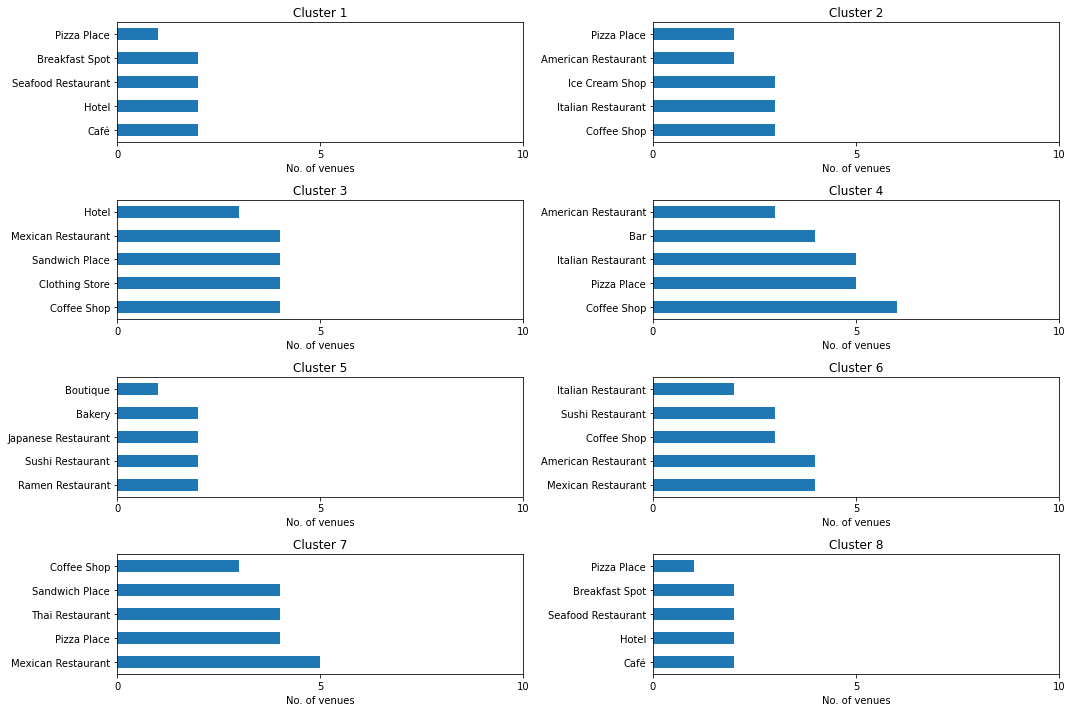

In [376]:
df_list = [venues1 ,venues2, venues3, venues4, venues5, venues6, venues7, venues1]
fig, axes = plt.subplots(4, 2)

count = 0
for r in range(4):
    for c in range(2):
            df_list[count].value_counts().head().plot.barh(ax = axes[r,c], width=0.5, figsize=(15,10))
            axes[r,c].set_title('Cluster {}'.format(count+1))
            plt.sca(axes[r, c])
            plt.xticks(np.arange(0, 15, 5))
            plt.xlabel('No. of venues')
            count += 1

fig.tight_layout()

In [385]:
# create map
cal_city_clusters_map = folium.Map(location=[latitude, longitude], zoom_start=6)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cal_city_merged['Neighborhood Latitude'], cal_city_merged['Neighborhood Longitude'], cal_city_merged['Neighborhood'], cal_city_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(cal_city_clusters_map)
       
cal_city_clusters_map